# Import packages

In [ ]:
! pip install torchinfo
! pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Fashion MNIST dataset


In [ ]:
import os 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

transfs = transforms.ToTensor()

# This will save the train and test datasets to a subfolder called FashionMNIST. 
# You can run os.getcwd() or pwd() to check what the current folder is

train = torchvision.datasets.FashionMNIST(root= os.getcwd(), train=True, transform=transfs, download=True)
test = torchvision.datasets.FashionMNIST(root = os.getcwd(), train=False, transform=transfs, download=True)

There 60,000 images in the training set and 10,000 images in the test set.

In [ ]:
len(train), len(test) 

(60000, 10000)

Each image has a resolution of 28x28 and only one channel.

In [ ]:
train[0][0].shape

torch.Size([1, 28, 28])

We can get the text labels for classes as follows.

In [ ]:
train.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
def get_labels(y):
    # Return text labels for the Fashion MNIST dataset.
    
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    
 
    return [labels[i] for i in y]

The following function will allow us to display the images.

In [ ]:
import matplotlib.pyplot as plt

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 
     
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    axes = axes.flatten()
    
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        if titles:
            ax.set_title(titles[i])
    return axes

Here's a batch of images from the training set. 

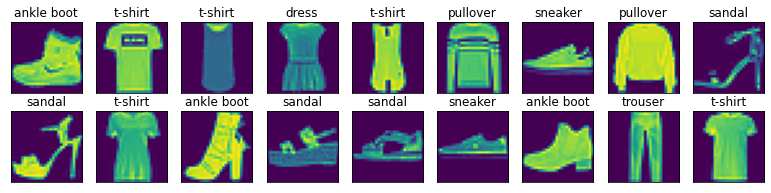

In [ ]:
X, y = next(iter(DataLoader(train, batch_size= 18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_text_labels(y));

# 1. Baseline model

## LeNet5 with Sigmoid activation

###  Build a CNN Achitecture

In [ ]:
# this is the most important cell in the tutorial!

import torch.nn as nn #First, import network
import torch.nn.functional as F #Import some functions into the network


class BaseLeNet5(nn.Module):
    def __init__(self): # Initial instance 
        super().__init__()
        
        # Convolutional layer 1
        # Inside the brackets: in_channels=1, out_channels=6 , kernel_size=5, padding=2
        # H_out = H_in (height) and W_out = W_in due to padding
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2) # Initiate an instance, then use the function to calculate the first layer.
                    # Inside the brackets: 3 channels, 32 pixels, 3-by-3 matrix)
        
        # Sigmoid
        self.sigmoid1 = nn.Sigmoid()

        # AvgPool layer 1
        # kernel_size = 2, stride = 2,
        self.pool1 = nn.AvgPool2d(2, 2)

        # Convolutional layer 2
        # Inside the brackets: in_channels=6, out_channels=16, kernel_size=5
        self.conv2 = nn.Conv2d(6, 16, 5)

        #Sigmoid2
        self.sigmoid2 = nn.Sigmoid()

        # AvgPool layer 2
        # kernel_size = 2, stride = 2 
        self.pool2 = nn.AvgPool2d(2, 2)

        #Flatten layer
        self.flatten = nn.Flatten()

        #FC(120)
        self.fc1 = nn.Linear(16*5*5, 120)

        #Sigmoid3
        self.sigmoid3 = nn.Sigmoid()

        #FC(84)
        self.fc2 = nn.Linear(120, 84)

        #Sigmoid4
        self.sigmoid4 = nn.Sigmoid()

        #FC(10)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        
        # Convolution 1
        x = self.conv1(x)

        #Sigmoid1
        x = self.sigmoid1(x)
        
        # Avg pooling 1
        x = self.pool1(x)
        
        # Convolution 2
        x = self.conv2(x)

        #Sigmoid2
        x = self.sigmoid2(x)
        
        # Avg pooling 2
        x = self.pool2(x)

        x = x.view(-1, 16*5*5)

        #FC(120)
        x = self.fc1(x)

        #Sigmoid3
        x = self.sigmoid3(x)

        #FC(84)
        x = self.fc2(x)

        #Sigmoid4
        x = self.sigmoid4(x)

        #FC(10)
        x = self.fc3(x)

        # Network returns vector of logits (not probabilities)
        return x

In [ ]:
# Inspect built model 
from torchinfo import summary

batch_size = 512
summary(BaseLeNet5(), input_size=(512, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BaseLeNet5                               [512, 10]                 --
├─Conv2d: 1-1                            [512, 6, 28, 28]          156
├─Sigmoid: 1-2                           [512, 6, 28, 28]          --
├─AvgPool2d: 1-3                         [512, 6, 14, 14]          --
├─Conv2d: 1-4                            [512, 16, 10, 10]         2,416
├─Sigmoid: 1-5                           [512, 16, 10, 10]         --
├─AvgPool2d: 1-6                         [512, 16, 5, 5]           --
├─Flatten: 1-7                           --                        --
├─Linear: 1-8                            [512, 120]                48,120
├─Sigmoid: 1-9                           [512, 120]                --
├─Linear: 1-10                           [512, 84]                 10,164
├─Sigmoid: 1-11                          [512, 84]                 --
├─Linear: 1-12                           [512, 10]                 850
To

### Training & Prediction

In [ ]:
# Training and Testing iterators
batch_size = 512

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers = 2)

validloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers =2)

In [ ]:
# Evaluation function
def evaluate(net, loader, device = None):
    
    if not device:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    # Set model to evaluation mode
    net.eval()
    
    # Number of observations
    num_samples = len(loader.dataset) 
    
    # Initialise metrics
    loss_fn = nn.CrossEntropyLoss()
    loss = 0.0
    accuracy = 0.0 
    
    for i, (X, y) in enumerate(loader):

        # Move data to GPU, if available
        X = X.to(device)
        y = y.to(device)
        
        with torch.no_grad(): 
            
            # Prediction
            output = net(X)   
            
            # Cross-entropy loss
            l = loss_fn(output, y).cpu().detach().numpy()
            loss +=  l*(len(y)/num_samples)
            
            # Accuracy
            y_hat = torch.argmax(output, dim = 1)
            correct = (y_hat == y).sum().cpu().detach().numpy()
            accuracy += correct/num_samples
    
    return loss, accuracy

In [ ]:
import time
from IPython.display import clear_output
from IPython.display import display, HTML

def train(model, trainloader, validloader, num_epochs = 2 , lr = 1e-3):
    
    # Get device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Instantiate model and move to device
    net = model().to(device)
    
    # Set up optimiser
    loss_fn = nn.CrossEntropyLoss() # this loss takes the logits as inputs
    optimiser = torch.optim.Adam(net.parameters(), lr = lr) 
    
    # Addding a learning rate scheduler to speed up training
    # See here: https://sgugger.github.io/the-1cycle-policy.html
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr = lr, 
                                                   steps_per_epoch=len(trainloader), epochs = num_epochs,
                                                   three_phase=True)
    
    # Training set size
    num_samples = len(trainloader.dataset)
    
    # Initialise table to track training
    table = pd.DataFrame(np.arange(1, num_epochs+1), columns = ['epoch'])
    table['train loss'] = 0.0
    table['train acc'] = 0.0
    table['valid loss'] = 0.0
    table['valid acc'] = 0.0
    table['time'] = ''
    
    print('Running first epoch')
    
    # Training loop
    for epoch in range(num_epochs):
        
        # Initialise timer
        epoch_start = time.time()
        
        # Set model to training mode
        net.train()
        
        # Initialise metrics
        train_loss = 0.0
        train_acc = 0.0
        
        # Iterate over minibatches
        for batch, (X, y) in enumerate(trainloader):

            # Move data to GPU, if available
            X = X.to(device)
            y = y.to(device)

            # Reset the gradient
            optimiser.zero_grad()

            # Compute predictions (forward pass)
            output = net(X)

            # Evaluate cost function
            loss = loss_fn(output, y)

            # Compute gradient (backward pass)
            loss.backward()

            # Update parameters
            optimiser.step()
            
            # Update scheduler
            scheduler.step()
            
            # Training set metrics   
            with torch.no_grad(): 

                # Cross-entropy loss
                l = loss.cpu().detach().numpy()
                train_loss +=  l*(len(y)/num_samples)

                # Accuracy
                y_hat = torch.argmax(output, dim = 1)
                correct = (y_hat == y).sum().cpu().detach().numpy()
                train_acc += correct/num_samples
            
        
        epoch_finish = time.time()
        
        # Run evalution function to get validation metrics
        valid_loss, valid_acc = evaluate(net, validloader, device)
        
        table.iloc[epoch, 1] = np.round(train_loss, 3)
        table.iloc[epoch, 2] = np.round(train_acc, 3)
        table.iloc[epoch, 3] = np.round(valid_loss, 3)
        table.iloc[epoch, 4] = np.round(valid_acc, 3)
        
        duration = epoch_finish - epoch_start
        if duration > 3600:
            table.iloc[epoch, 5] = time.strftime('%H:%M:%S', time.gmtime(duration))
        else:
            table.iloc[epoch, 5] = time.strftime('%M:%S', time.gmtime(duration))
        
        clear_output()
        display(HTML(table.iloc[:epoch+1, :].to_html(index=False)))
    
    return net, table

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.70E-02


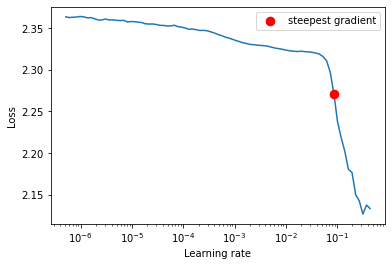

In [ ]:
# Finding the learning rate for Baseline model
from torch_lr_finder import LRFinder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BaseLeNet5()
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-7)
lr_finder = LRFinder(model, optimiser, criterion, device = device)
lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
lr_finder.plot() 
lr_finder.reset() 

In [ ]:
# Train & Predict for baseline model
net, table = train(BaseLeNet5, trainloader, validloader, num_epochs = 30, lr = 8.70E-02)

epoch,train loss,train acc,valid loss,valid acc,time
1,1.870,0.275,1.063,0.542,00:16
2,0.834,0.672,0.721,0.723,00:16
3,0.580,0.778,0.530,0.799,00:16
4,0.475,0.822,0.559,0.784,00:16
5,0.432,0.838,0.443,0.834,00:16
6,0.429,0.840,0.498,0.826,00:17
7,0.408,0.850,0.443,0.838,00:23
8,0.399,0.854,0.479,0.819,00:37
9,0.382,0.860,0.460,0.829,00:37
10,0.367,0.865,0.408,0.846,00:41


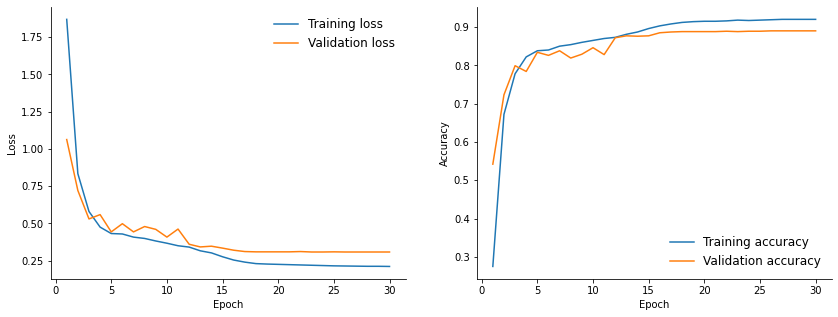

In [ ]:
# Loss and Accuracy on training and testing sets across epochs
fig , axes = plt.subplots(1, 2, figsize=(14, 5))
axes = axes.flatten()

axes[0].plot(table['epoch'], table['train loss'], label = 'Training loss')
axes[0].plot(table['epoch'], table['valid loss'], label = 'Validation loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(fontsize=12, frameon=False)

axes[1].plot(table['epoch'], table['train acc'], label = 'Training accuracy')
axes[1].plot(table['epoch'], table['valid acc'], label = 'Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(fontsize=12, frameon=False)

sns.despine()
plt.show()

### Evaluation

In [ ]:
# Functions - All predictions for the test set 

def inference(net, loader, device = None):
    
    if not device:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    # Set model to evaluation mode
    net.eval()
    
    # Number of observations
    num_samples = len(loader.dataset) 
    num_classes = len(loader.dataset.classes)
    
    # Initialise metrics
    target = np.zeros(num_samples, dtype=int)
    predictions = np.zeros(num_samples, dtype=int)
    probabilities = np.zeros((num_samples, num_classes))
    losses = np.zeros(num_samples)
    
    index = 0
    
    for i, (X, y) in enumerate(loader):
    
        batch_size = len(y)
        
        target[index:index+batch_size] = y.numpy()
        
        # Move data to GPU, if available
        X = X.to(device)
        y = y.to(device)
        
        with torch.no_grad(): 
            
            # Network output
            output = net(X)   
            
            # Losses
            l = F.cross_entropy(output, y, reduction='none').cpu().detach().numpy()
            losses[index:index+batch_size] = l
            
            # Predicted class
            y_hat = torch.argmax(output, dim = 1).cpu().detach().numpy()
            predictions[index:index+batch_size] = y_hat
        
            # Predicted probability
            y_prob = torch.softmax(output, dim=1).cpu().detach().numpy()
            probabilities[index:index+batch_size] = y_prob
            
        index += batch_size
            
    
    return target, predictions, probabilities, losses

In [ ]:
# Inference of baseline model
target_base, preds_base, probs_base, losses_base = inference(net, validloader)

In [ ]:
# Classification report
from sklearn.metrics import classification_report

labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

print(classification_report(target_base, preds_base, target_names = labels))

              precision    recall  f1-score   support

     t-shirt       0.83      0.84      0.84      1000
     trouser       0.99      0.97      0.98      1000
    pullover       0.81      0.83      0.82      1000
       dress       0.89      0.90      0.89      1000
        coat       0.81      0.79      0.80      1000
      sandal       0.98      0.98      0.98      1000
       shirt       0.69      0.68      0.69      1000
     sneaker       0.94      0.97      0.96      1000
         bag       0.97      0.98      0.97      1000
  ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix

labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

C_base = pd.DataFrame(confusion_matrix(target_base, preds_base), index = labels, columns=labels)
C_base

,t-shirt,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,ankle boot
t-shirt,839,1,12,22,2,2,117,0,5,0
trouser,2,970,0,21,1,0,4,0,2,0
pullover,14,0,828,8,76,0,73,0,1,0
dress,16,5,8,903,36,1,29,0,2,0
coat,0,1,94,37,789,0,75,0,4,0
sandal,0,0,0,0,0,981,0,15,0,4
shirt,132,0,76,23,71,0,684,0,14,0
sneaker,0,0,0,0,0,15,0,967,1,17
bag,4,0,1,4,5,2,3,3,978,0
ankle boot,1,0,0,0,0,4,0,39,0,956


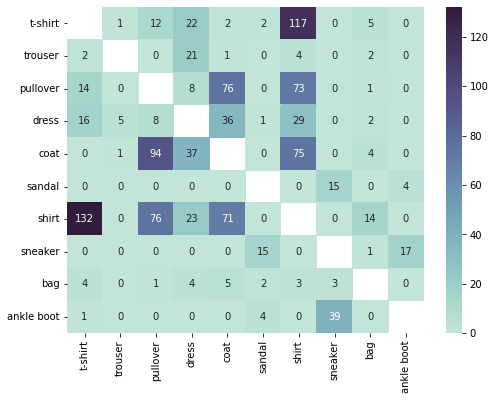

In [ ]:
# Misclassification count
mask = np.zeros_like(C_base)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(C_base, annot= True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), mask =np.eye(10, dtype=int), fmt = 'd')

# 2. Improvements

## LeNet5 with ReLu activation

### Build a CNN architecture

In [ ]:
# this is the most important cell in the tutorial!

import torch.nn as nn #First, import network
import torch.nn.functional as F #Import some functions into the network


class Net(nn.Module):
    def __init__(self): # Initial instance 
        super().__init__()
        
        # Convolutional layer 1
        # Inside the brackets: in_channels=1, out_channels=6 , kernel_size=5, padding=2
        # H_out = H_in (height) and W_out = W_in due to padding
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2) # Initiate an instance, then use the function to calculate the first layer.
                    # Inside the brackets: 3 channels, 32 pixels, 3-by-3 matrix)
        
        # ReLu1
        self.relu1 = nn.ReLU()

        # AvgPool layer 1
        # kernel_size = 2, stride = 2,
        self.pool1 = nn.AvgPool2d(2, 2)

        # Convolutional layer 2
        # Inside the brackets: in_channels=6, out_channels=16, kernel_size=5
        self.conv2 = nn.Conv2d(6, 16, 5)

        #ReLu2
        self.relu2 = nn.ReLU()

        # AvgPool layer 2
        # kernel_size = 2, stride = 2 
        self.pool2 = nn.AvgPool2d(2, 2)

        #Flatten layer
        self.flatten = nn.Flatten()

        #FC(120)
        self.fc1 = nn.Linear(16*5*5, 120)

        #Relu3
        self.relu3 = nn.ReLU()

        #FC(84)
        self.fc2 = nn.Linear(120, 84)

        #ReLu4
        self.relu4 = nn.ReLU()

        #FC(10)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        
        # Convolution 1
        x = self.conv1(x)

        #ReLu1
        x = self.relu1(x)
        
        # Avg pooling 1
        x = self.pool1(x)
        
        # Convolution 2
        x = self.conv2(x)

        #ReLu2
        x = self.relu2(x)
        
        # Avg pooling 2
        x = self.pool2(x)

        x = x.view(-1, 16*5*5)

        #FC(120)
        x = self.fc1(x)

        #ReLu2
        x = self.relu3(x)

        #FC(84)
        x = self.fc2(x)

        #ReLu4
        x = self.relu4(x)

        #FC(10)
        x = self.fc3(x)

        # Network returns vector of logits (not probabilities)
        return x

In [ ]:
# Inspect built model 
from torchinfo import summary

batch_size = 512
summary(Net(), input_size=(512, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [512, 10]                 --
├─Conv2d: 1-1                            [512, 6, 28, 28]          156
├─ReLU: 1-2                              [512, 6, 28, 28]          --
├─AvgPool2d: 1-3                         [512, 6, 14, 14]          --
├─Conv2d: 1-4                            [512, 16, 10, 10]         2,416
├─ReLU: 1-5                              [512, 16, 10, 10]         --
├─AvgPool2d: 1-6                         [512, 16, 5, 5]           --
├─Flatten: 1-7                           --                        --
├─Linear: 1-8                            [512, 120]                48,120
├─ReLU: 1-9                              [512, 120]                --
├─Linear: 1-10                           [512, 84]                 10,164
├─ReLU: 1-11                             [512, 84]                 --
├─Linear: 1-12                           [512, 10]                 850
To

### Training & Prediction

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.56E-03


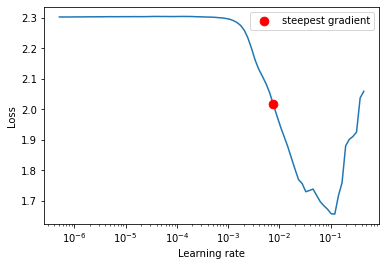

In [ ]:
from torch_lr_finder import LRFinder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Net()
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-7)
lr_finder = LRFinder(model, optimiser, criterion, device = device)
lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
lr_finder.plot() 
lr_finder.reset() 

In [ ]:
# Train and Predict for Improvement model 1
net, table = train(Net, trainloader, validloader, num_epochs = 30, lr = 7.56E-03)

epoch,train loss,train acc,valid loss,valid acc,time
1,1.622,0.465,0.850,0.673,00:16
2,0.739,0.726,0.681,0.749,00:16
3,0.628,0.763,0.598,0.765,00:17
4,0.545,0.794,0.623,0.767,00:19
5,0.495,0.815,0.503,0.799,00:16
6,0.435,0.840,0.446,0.838,00:16
7,0.387,0.858,0.393,0.859,00:16
8,0.348,0.872,0.539,0.807,00:17
9,0.322,0.881,0.348,0.873,00:19
10,0.301,0.889,0.330,0.877,00:16


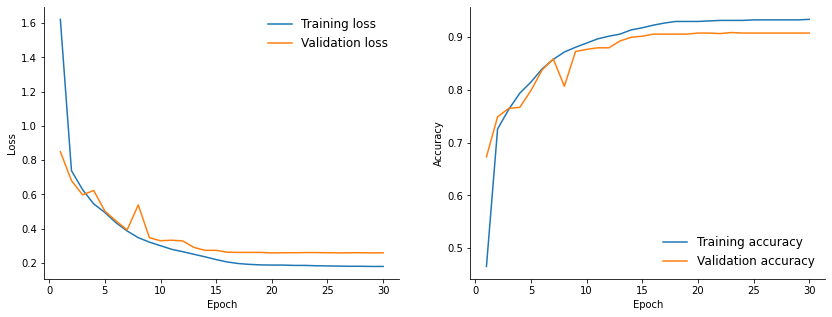

In [ ]:
# Loss and Accuracy on training and testing sets across epochs
fig , axes = plt.subplots(1, 2, figsize=(14, 5))
axes = axes.flatten()

axes[0].plot(table['epoch'], table['train loss'], label = 'Training loss')
axes[0].plot(table['epoch'], table['valid loss'], label = 'Validation loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(fontsize=12, frameon=False)

axes[1].plot(table['epoch'], table['train acc'], label = 'Training accuracy')
axes[1].plot(table['epoch'], table['valid acc'], label = 'Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(fontsize=12, frameon=False)

sns.despine()
plt.show()

### Evaluation

In [ ]:
# Inference
target, preds, probs, losses = inference(net, validloader)

In [ ]:
# Classification report
from sklearn.metrics import classification_report

labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

print(classification_report(target, preds, target_names = labels))

              precision    recall  f1-score   support

     t-shirt       0.85      0.86      0.85      1000
     trouser       0.99      0.98      0.98      1000
    pullover       0.86      0.85      0.85      1000
       dress       0.91      0.91      0.91      1000
        coat       0.82      0.86      0.84      1000
      sandal       0.98      0.98      0.98      1000
       shirt       0.76      0.73      0.75      1000
     sneaker       0.95      0.97      0.96      1000
         bag       0.98      0.98      0.98      1000
  ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



The accuracy of the baseline model is 91% on the test set.

In [ ]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix

labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

C1 = pd.DataFrame(confusion_matrix(target, preds), index = labels, columns=labels)
C1

,t-shirt,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,ankle boot
t-shirt,856,2,16,16,6,1,98,0,5,0
trouser,1,979,0,14,2,0,4,0,0,0
pullover,15,1,849,6,72,0,56,0,1,0
dress,17,3,12,909,35,0,23,0,1,0
coat,0,1,57,26,865,0,50,0,1,0
sandal,0,0,0,0,0,978,0,13,1,8
shirt,110,2,52,22,72,1,733,0,8,0
sneaker,0,0,0,0,0,9,0,972,1,18
bag,5,0,2,4,0,2,1,2,983,1
ankle boot,1,0,0,0,0,5,0,39,0,955


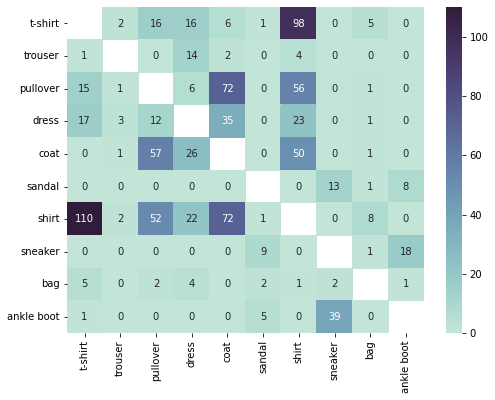

In [ ]:
# Misclassification count
mask = np.zeros_like(C1)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(C1, annot= True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), mask =np.eye(10, dtype=int), fmt = 'd')

## LeNet5 with ReLU, Batch normalisation & Max Pooling

### Build a CNN architecture

In [ ]:
# this is the most important cell in the tutorial!

import torch.nn as nn #First, import network
import torch.nn.functional as F #Import some functions into the network


class LN5_ReLu_BN_MP(nn.Module):
    def __init__(self): # Initial instance 
        super().__init__()
        
        # Convolutional layer 1
        # Inside the brackets: in_channels=1, out_channels=6 , kernel_size=5, padding=2
        # H_out = H_in (height) and W_out = W_in due to padding
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2) # Initiate an instance, then use the function to calculate the first layer.
                    # Inside the brackets: 3 channels, 32 pixels, 3-by-3 matrix)

        #Batch normalisation layer 1
        self.bn1 = nn.BatchNorm2d(6)
        
        # ReLu1
        self.relu1 = nn.ReLU()

        # MaxPooling layer 1
        # kernel_size = 2, stride = 2,
        self.pool1 = nn.MaxPool2d(2, 2)

        # Convolutional layer 2
        # Inside the brackets: in_channels=6, out_channels=16, kernel_size=5
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Batch normalisation layer 2
        self.bn2 = nn.BatchNorm2d(16)

        #ReLu2
        self.relu2 = nn.ReLU()

        # Maxpooling layer 2
        # kernel_size = 2, stride = 2 
        self.pool2 = nn.MaxPool2d(2, 2)

        #FC(120)
        self.fc1 = nn.Linear(16*5*5, 120)

        #Relu3
        self.relu3 = nn.ReLU()

        #FC(84)
        self.fc2 = nn.Linear(120, 84)

        #ReLu4
        self.relu4 = nn.ReLU()

        #FC(10)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        
        # Convolution 1
        x = self.conv1(x)

        # Batch normalisation 1
        x = self.bn1(x)

        #ReLu1
        x = self.relu1(x)
        
        # Avg pooling 1
        x = self.pool1(x)
        
        # Convolution 2
        x = self.conv2(x)

        # Batch normalisation 2
        x = self.bn2(x)

        #ReLu2
        x = self.relu2(x)
        
        # Avg pooling 2
        x = self.pool2(x)

        x = x.view(-1, 16*5*5)

        #FC(120)
        x = self.fc1(x)

        #ReLu2
        x = self.relu3(x)

        #FC(84)
        x = self.fc2(x)

        #ReLu4
        x = self.relu4(x)

        #FC(10)
        x = self.fc3(x)

        # Network returns vector of logits (not probabilities)
        return x

In [ ]:
# Inspect built model 
from torchinfo import summary

batch_size = 512
summary(LN5_ReLu_BN_MP(), input_size=(512, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LN5_ReLu_BN_MP                           [512, 10]                 --
├─Conv2d: 1-1                            [512, 6, 28, 28]          156
├─BatchNorm2d: 1-2                       [512, 6, 28, 28]          12
├─ReLU: 1-3                              [512, 6, 28, 28]          --
├─MaxPool2d: 1-4                         [512, 6, 14, 14]          --
├─Conv2d: 1-5                            [512, 16, 10, 10]         2,416
├─BatchNorm2d: 1-6                       [512, 16, 10, 10]         32
├─ReLU: 1-7                              [512, 16, 10, 10]         --
├─MaxPool2d: 1-8                         [512, 16, 5, 5]           --
├─Linear: 1-9                            [512, 120]                48,120
├─ReLU: 1-10                             [512, 120]                --
├─Linear: 1-11                           [512, 84]                 10,164
├─ReLU: 1-12                             [512, 84]                 --
├─L

### Training & Prediction

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.85E-03


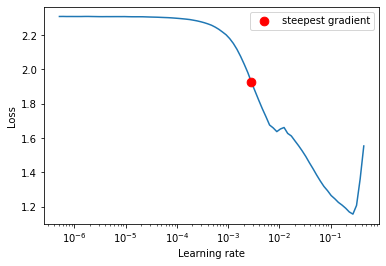

In [ ]:
from torch_lr_finder import LRFinder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LN5_ReLu_BN_MP()
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-7)
lr_finder = LRFinder(model, optimiser, criterion, device = device)
lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
lr_finder.plot() 
lr_finder.reset() 

In [ ]:
# Train and Predict for Improvement model 2
net4, table4 = train(LN5_ReLu_BN_MP, trainloader, validloader, num_epochs = 30, lr = 2.85E-03)

epoch,train loss,train acc,valid loss,valid acc,time
1,1.617,0.576,0.817,0.742,00:19
2,0.598,0.782,0.494,0.820,00:18
3,0.423,0.848,0.411,0.850,00:18
4,0.356,0.872,0.374,0.863,00:19
5,0.320,0.884,0.377,0.863,00:19
6,0.303,0.889,0.349,0.874,00:18
7,0.280,0.898,0.371,0.864,00:18
8,0.273,0.900,0.373,0.860,00:18
9,0.255,0.906,0.283,0.898,00:18
10,0.245,0.908,0.316,0.883,00:18


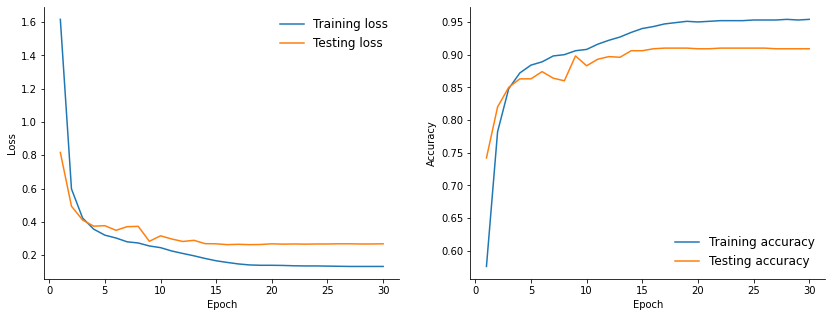

In [ ]:
# Loss and Accuracy on training and testing sets across epochs
fig , axes = plt.subplots(1, 2, figsize=(14, 5))
axes = axes.flatten()

axes[0].plot(table4['epoch'], table4['train loss'], label = 'Training loss')
axes[0].plot(table4['epoch'], table4['valid loss'], label = 'Testing loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(fontsize=12, frameon=False)

axes[1].plot(table4['epoch'], table4['train acc'], label = 'Training accuracy')
axes[1].plot(table4['epoch'], table4['valid acc'], label = 'Testing accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(fontsize=12, frameon=False)

sns.despine()
plt.show()

### Evaluation

In [ ]:
# Inference
target4, preds4, probs4, losses4 = inference(net4, validloader)

In [ ]:
# Classification report
from sklearn.metrics import classification_report

labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

print(classification_report(target4, preds4, target_names = labels))

              precision    recall  f1-score   support

     t-shirt       0.86      0.86      0.86      1000
     trouser       0.99      0.98      0.99      1000
    pullover       0.87      0.86      0.86      1000
       dress       0.91      0.92      0.91      1000
        coat       0.84      0.86      0.85      1000
      sandal       0.98      0.98      0.98      1000
       shirt       0.75      0.74      0.75      1000
     sneaker       0.95      0.97      0.96      1000
         bag       0.98      0.98      0.98      1000
  ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix

labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

C4 = pd.DataFrame(confusion_matrix(target4, preds4), index = labels, columns=labels)
C4

,t-shirt,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,ankle boot
t-shirt,858,0,14,21,5,2,95,0,5,0
trouser,2,985,1,8,2,0,1,0,1,0
pullover,16,0,857,9,54,0,63,0,1,0
dress,16,5,7,916,28,0,24,0,4,0
coat,2,1,50,27,861,0,57,0,2,0
sandal,0,0,0,0,0,977,0,17,0,6
shirt,100,1,58,26,68,0,737,0,10,0
sneaker,0,0,0,0,0,15,0,966,0,19
bag,4,1,2,5,4,1,0,5,978,0
ankle boot,0,0,0,0,0,6,1,34,0,959


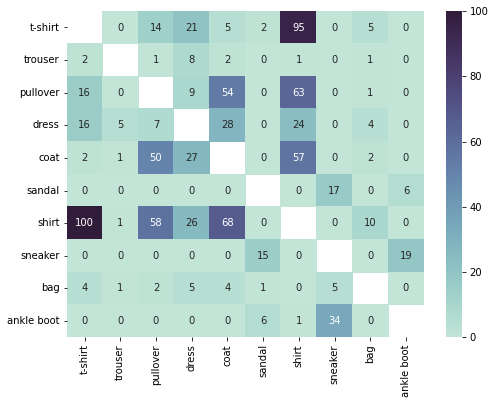

In [ ]:
# Misclassification count
mask = np.zeros_like(C)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(C4, annot= True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), mask =np.eye(10, dtype=int), fmt = 'd')

# 3. Final model


## LeNet5 with ReLu, Batch Normalisation & Average Pooling

### Build a CNN architecture

In [ ]:
# this is the most important cell in the tutorial!

import torch.nn as nn #First, import network
import torch.nn.functional as F #Import some functions into the network


class LeNet5ReLuBN(nn.Module):
    def __init__(self): # Initial instance 
        super().__init__()
        
        # Convolutional layer 1
        # Inside the brackets: in_channels=1, out_channels=6 , kernel_size=5, padding=2
        # H_out = H_in (height) and W_out = W_in due to padding
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2) # Initiate an instance, then use the function to calculate the first layer.
                    # Inside the brackets: 3 channels, 32 pixels, 3-by-3 matrix)

        #Batch normalisation layer 1
        self.bn1 = nn.BatchNorm2d(6)
        
        # ReLu1
        self.relu1 = nn.ReLU()

        # AvgPool layer 1
        # kernel_size = 2, stride = 2,
        self.pool1 = nn.AvgPool2d(2, 2)

        # Convolutional layer 2
        # Inside the brackets: in_channels=6, out_channels=16, kernel_size=5
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Batch normalisation layer 2
        self.bn2 = nn.BatchNorm2d(16)

        #ReLu2
        self.relu2 = nn.ReLU()

        # AvgPool layer 2
        # kernel_size = 2, stride = 2 
        self.pool2 = nn.AvgPool2d(2, 2)

        #Flatten layer
        self.flatten = nn.Flatten()

        #FC(120)
        self.fc1 = nn.Linear(16*5*5, 120)

        #Relu3
        self.relu3 = nn.ReLU()

        #FC(84)
        self.fc2 = nn.Linear(120, 84)

        #ReLu4
        self.relu4 = nn.ReLU()

        #FC(10)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        
        # Convolution 1
        x = self.conv1(x)

        # Batch normalisation 1
        x = self.bn1(x)

        #ReLu1
        x = self.relu1(x)
        
        # Avg pooling 1
        x = self.pool1(x)
        
        # Convolution 2
        x = self.conv2(x)

        # Batch normalisation 2
        x = self.bn2(x)

        #ReLu2
        x = self.relu2(x)
        
        # Avg pooling 2
        x = self.pool2(x)

        x = x.view(-1, 16*5*5)

        #FC(120)
        x = self.fc1(x)

        #ReLu2
        x = self.relu3(x)

        #FC(84)
        x = self.fc2(x)

        #ReLu4
        x = self.relu4(x)

        #FC(10)
        x = self.fc3(x)

        # Network returns vector of logits (not probabilities)
        return x

In [ ]:
# Inspect built model 
from torchinfo import summary

batch_size = 512
summary(LeNet5ReLuBN(), input_size=(512, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5ReLuBN                             [512, 10]                 --
├─Conv2d: 1-1                            [512, 6, 28, 28]          156
├─BatchNorm2d: 1-2                       [512, 6, 28, 28]          12
├─ReLU: 1-3                              [512, 6, 28, 28]          --
├─AvgPool2d: 1-4                         [512, 6, 14, 14]          --
├─Conv2d: 1-5                            [512, 16, 10, 10]         2,416
├─BatchNorm2d: 1-6                       [512, 16, 10, 10]         32
├─ReLU: 1-7                              [512, 16, 10, 10]         --
├─AvgPool2d: 1-8                         [512, 16, 5, 5]           --
├─Flatten: 1-9                           --                        --
├─Linear: 1-10                           [512, 120]                48,120
├─ReLU: 1-11                             [512, 120]                --
├─Linear: 1-12                           [512, 84]                 10,164
├─R

### Training & Prediction

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.94E-03


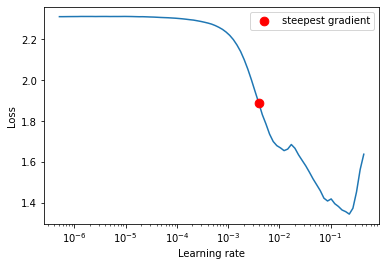

In [ ]:
from torch_lr_finder import LRFinder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LeNet5ReLuBN()
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-7)
lr_finder = LRFinder(model, optimiser, criterion, device = device)
lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
lr_finder.plot() 
lr_finder.reset() 

In [ ]:
# Train and Predict for Improvement model 2
net3, table3 = train(LeNet5ReLuBN, trainloader, validloader, num_epochs = 30, lr = 3.94E-03)

epoch,train loss,train acc,valid loss,valid acc,time
1,1.617,0.556,0.876,0.705,00:26
2,0.630,0.765,0.518,0.810,00:37
3,0.439,0.838,0.420,0.853,00:22
4,0.369,0.865,0.375,0.865,00:23
5,0.322,0.883,0.341,0.876,00:30
6,0.299,0.890,0.369,0.869,00:35
7,0.286,0.895,0.325,0.883,00:26
8,0.264,0.903,0.460,0.833,00:19
9,0.254,0.905,0.303,0.886,00:21
10,0.236,0.912,0.302,0.892,00:19


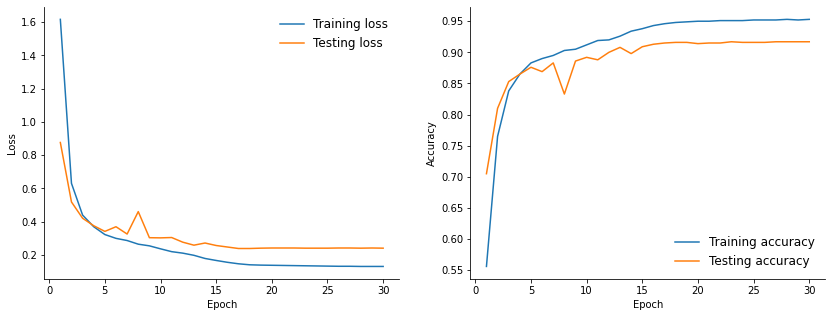

In [ ]:
# Loss and Accuracy on training and testing sets across epochs
fig , axes = plt.subplots(1, 2, figsize=(14, 5))
axes = axes.flatten()

axes[0].plot(table3['epoch'], table3['train loss'], label = 'Training loss')
axes[0].plot(table3['epoch'], table3['valid loss'], label = 'Testing loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(fontsize=12, frameon=False)

axes[1].plot(table3['epoch'], table3['train acc'], label = 'Training accuracy')
axes[1].plot(table3['epoch'], table3['valid acc'], label = 'Testing accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(fontsize=12, frameon=False)

sns.despine()
plt.show()

### Evaluation

In [ ]:
# Inference
target3, preds3, probs3, losses3 = inference(net3, validloader)

In [ ]:
# Classification report
from sklearn.metrics import classification_report

labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

print(classification_report(target3, preds3, target_names = labels))

              precision    recall  f1-score   support

     t-shirt       0.87      0.86      0.86      1000
     trouser       0.99      0.99      0.99      1000
    pullover       0.87      0.88      0.87      1000
       dress       0.93      0.92      0.93      1000
        coat       0.85      0.88      0.86      1000
      sandal       0.98      0.99      0.98      1000
       shirt       0.77      0.74      0.76      1000
     sneaker       0.96      0.97      0.97      1000
         bag       0.98      0.99      0.98      1000
  ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix

labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

C3 = pd.DataFrame(confusion_matrix(target3, preds3), index = labels, columns=labels)
C3

,t-shirt,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,ankle boot
t-shirt,860,1,18,8,5,1,97,0,10,0
trouser,0,987,0,8,2,0,2,0,1,0
pullover,13,3,876,7,49,0,51,0,1,0
dress,12,4,10,922,26,0,22,0,4,0
coat,0,0,52,22,877,0,48,0,1,0
sandal,0,1,0,0,0,986,0,10,0,3
shirt,105,2,51,22,70,0,744,0,6,0
sneaker,0,0,0,0,0,10,0,969,0,21
bag,4,1,0,3,2,1,2,0,987,0
ankle boot,0,0,0,0,0,9,0,28,0,963


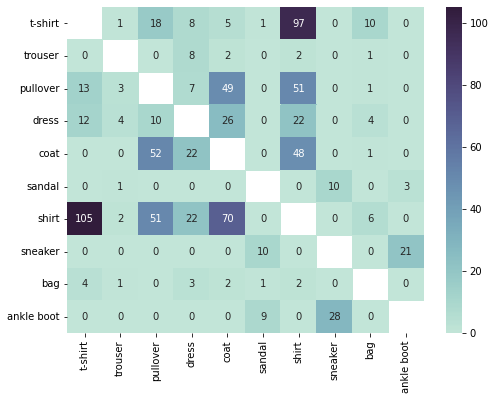

In [ ]:
# Misclassification count
mask = np.zeros_like(C3)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(C3, annot= True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), mask =np.eye(10, dtype=int), fmt = 'd')